<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [58]:
# pip install watermark
%load_ext watermark

In [59]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.5.0

numpy 1.16.3
scipy 1.2.1
pandas 0.24.2
matplotlib 3.0.3
statsmodels 0.9.0
sklearn 0.21.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores  : 2
interpreter: 64bit
Git hash   : 3513b6f47d8182a7a648434307003db29ef8aeba


In [3]:
# %watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

In [60]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import time

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [4]:
def save_answer_Array(fnameNum, array):
    with open('dminik6_w4_{}.txt'.format(fnameNum),"w") as fout:
        fout.write(" ".join(['{:.3f}'.format(el) for el in array]))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
def test_KNeighbors(knn, X, y, skf):
    m = []
    # skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
    #skf.get_n_splits(X, y)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        m.append( [knn.score(X_train, y_train), knn.score(X_test, y_test)])
        #m.append( knn.score(X_train, y_train) )
    return m

# 

In [12]:
%%time
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1).fit(X_train, y_train)
# Разобраться, почему test_KNeighbors и cross_val_score возвращают разные значения
# хотя при выполнении Вопроса 3 решение принято.
###ans_1_0 = test_KNeighbors(knn,  X_train, y_train) 

###print(ans_1_0, ans_1_00)

Wall time: 1.09 ms


In [ ]:
# %%time
# ans_1_1 = test_KNeighbors(knn,  X_train, y_train, skf)

# # print('{:.3f}'.format(ans_1_1))

In [15]:
#ans_1_1

In [17]:
#cross_val_score(knn, X_train, y_train, cv=skf)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [18]:
%%time
# Ответ на вопрос 1
ans_1_00 = cross_val_score(knn, X_train, y_train, cv=skf).mean()
ans_1_10 = knn.score(X_valid, y_valid)
print('Доля правильных ответов для KNeighborsClassifier на кросс-валидации    {:.3f}'.format(ans_1_00))
print('Доля правильных ответов для KNeighborsClassifier на отложенной выборке {:.3f}'.format(ans_1_10))
save_answer_Array(1, [ans_1_00, ans_1_10])
# Доля правильных ответов для KNeighborsClassifier на кросс-валидации    0.562
# Доля правильных ответов для KNeighborsClassifier на отложенной выборке 0.582

Доля правильных ответов для KNeighborsClassifier на кросс-валидации    0.561
Доля правильных ответов для KNeighborsClassifier на отложенной выборке 0.582
Wall time: 8.39 s


**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
%%time
forest = RandomForestClassifier(n_estimators=100, random_state=17, 
                                n_jobs=-1, oob_score=True).fit( X_train, y_train)

Wall time: 9.85 s


In [23]:
# forest.oob_score_

In [22]:
#ans_2_0 = forest.score(X_train, y_train)
#ans_2_00 = cross_val_score(forest, X_train, y_train, cv=skf).mean()


**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [21]:
%%time
ans_2_01 = forest.oob_score_
ans_2_1 = forest.score(X_valid, y_valid)
print('Доля правильных ответов по Out-of-Bag оценке                             {:.3f}'.format(ans_2_01))
print('Доля правильных ответов для RandomForestClassifier на отложенной выборке {:.3f}'.format(ans_2_1))
save_answer_Array(2, [ans_2_01, ans_2_1])
# Доля правильных ответов по Out-of-Bag оценке                             0.725
# Доля правильных ответов для RandomForestClassifier на отложенной выборке 0.729

Доля правильных ответов по Out-of-Bag оценке                             0.725
Доля правильных ответов для RandomForestClassifier на отложенной выборке 0.727
Wall time: 205 ms


In [24]:
#!cat answer4_2.txt

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [36]:
%%time
logit = LogisticRegression(C=1.0, random_state=17).fit(X_train, y_train)

Wall time: 1.35 s


In [39]:
#logit.score(X_train, y_train)
#cross_val_score(logit, X_train, y_train, cv=skf)

In [38]:
#ans_3_0=test_KNeighbors(logit, X_train, y_train, skf)
val_cv =cross_val_score(logit, X_train, y_train, cv=skf).mean()
val_val=logit.score(X_valid, y_valid)
print('Доля правильных ответов для LogisticRegression на кросс-валидации    {:.3f}'.format(val_cv))
print('Доля правильных ответов для LogisticRegression на отложенной выборке {:.3f}'.format(val_val))

Доля правильных ответов для LogisticRegression на кросс-валидации    0.763
Доля правильных ответов для LogisticRegression на отложенной выборке 0.780


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [42]:
%%time 
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, multi_class='multinomial', 
                                             random_state=17, max_iter=2000)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 2min 17s


In [44]:
#logit_grid_searcher1.scores_
# for l in logit_grid_searcher1.scores_:
#     print ('Max auc_roc:', logit_grid_searcher1.scores_[l].mean(axis=0).max())  # is correct

In [ ]:
# train_scores, test_scores = validation_curve(
#     SVC(), X, y, param_name="gamma", param_range=param_range,
#     cv=5, scoring="accuracy", n_jobs=1)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.title("Validation Curve with SVM")
# plt.xlabel(r"$\gamma$")
# plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
# lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
# plt.legend(loc="best")
# plt.show()

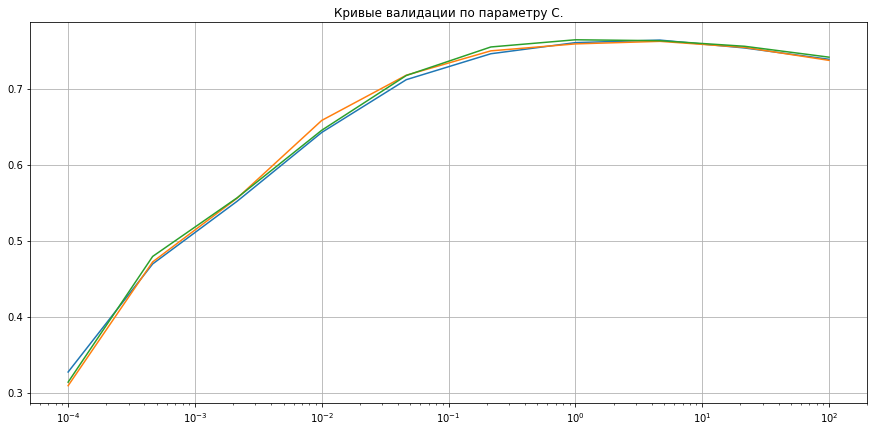

In [45]:
#logit_grid_searcher1.scores_
#print(logit_grid_searcher1.scores_[31])
ascores = np.array(next(iter(logit_grid_searcher1.scores_.values())))

#print(ascores)

#print(ascores.mean(axis=0).argmax())
#plt.plot(logit_c_values1, score_mean)
plt.figure(figsize=(15, 7))
for l in ascores:
    plt.plot(logit_c_values1, l)
plt.xscale('log')
plt.grid(True)
plt.title('Кривые валидации по параметру C.')

plt.show()

In [46]:
set(y_train)

{31, 33, 39, 50, 100, 127, 128, 207, 237, 241}

In [47]:
score = logit_grid_searcher1.score(X_valid, y_valid)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [48]:
logit_mean_cv_scores1 = ascores.mean(axis=0) # ''' ВАШ КОД ЗДЕСЬ '''

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [49]:
best_pos = logit_mean_cv_scores1.argmax() #''' ВАШ КОД ЗДЕСЬ '''
print('Выведите лучшее значение доли правильных ответов на кросс-валидации:{}\n'
      'и соответствующее значение C: {}'.format(logit_mean_cv_scores1[best_pos], logit_c_values1[best_pos] ))

Выведите лучшее значение доли правильных ответов на кросс-валидации:0.76295418489589
и соответствующее значение C: 4.641588833612772


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

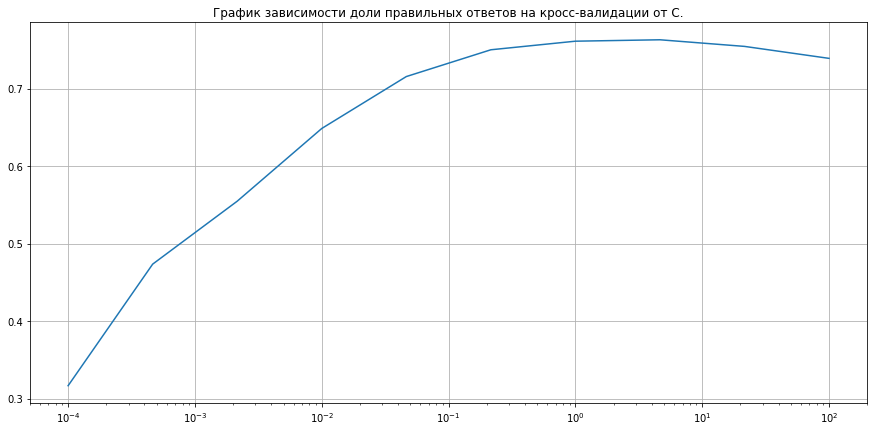

In [50]:
plt.figure(figsize=(15, 7))
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.xscale('log')
plt.grid(True)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C.')

plt.show()

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [52]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, multi_class='multinomial', 
                                            n_jobs=-1, random_state=17, max_iter=2000) # ''' ВАШ КОД ЗДЕСЬ '''
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 54s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [53]:
#''' ВАШ КОД ЗДЕСЬ '''
ascores2 = np.array(next(iter(logit_grid_searcher2.scores_.values())))
logit_mean_cv_scores2 = ascores2.mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [54]:
#''' ВАШ КОД ЗДЕСЬ '''
best_pos2 = logit_mean_cv_scores2.argmax() #''' ВАШ КОД ЗДЕСЬ '''
print('Выведите лучшее значение доли правильных ответов на кросс-валидации:{}\n'
      'и соответствующее значение C: {}'.format(logit_mean_cv_scores2[best_pos2], logit_c_values2[best_pos2] ))

Выведите лучшее значение доли правильных ответов на кросс-валидации:0.7637679057519019
и соответствующее значение C: 1.5526315789473686


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(logit_c_values2, logit_mean_cv_scores2)
#plt.xscale('log')
plt.grid(True)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C.')
plt.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [ ]:
logit_grid_searcher2.C_

In [ ]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
#''' ВАШ КОД ЗДЕСЬ '''
# Демонстрация того, что результат одинаков.
print(logit_cv_acc)
print(logit_grid_searcher2.score(X_valid, y_valid))

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
#''' ВАШ КОД ЗДЕСЬ '''
ans_3_0 = logit_mean_cv_scores2[best_pos2]
ans_3_1 = logit_grid_searcher2.score(X_valid, y_valid)
print('{:.3f}, {:.3f}'.format(ans_3_0, ans_3_1))
save_answer_Array(3, [ans_3_0, ans_3_1])

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [69]:
from sklearn.svm import LinearSVC

In [71]:
#''' ВАШ КОД ЗДЕСЬ '''
svm = LinearSVC(C=1., random_state=17).fit(X_train, y_train)
###print('доля правильных ответов на кросс-валидации    {:.3f}'.format(test_KNeighbors(svm, X_train, y_train)))
### print('доля правильных ответов на отложенной выборке {:.3f}'.format(svm.score(X_valid, y_valid)))

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [72]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, cv=skf, n_jobs=-1)
#''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 1s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [76]:
#''' ВАШ КОД ЗДЕСЬ '''
print(svm_grid_searcher1.best_score_)
print(svm_grid_searcher1.best_params_)

0.6890875838244259
{'C': 1111.1112}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

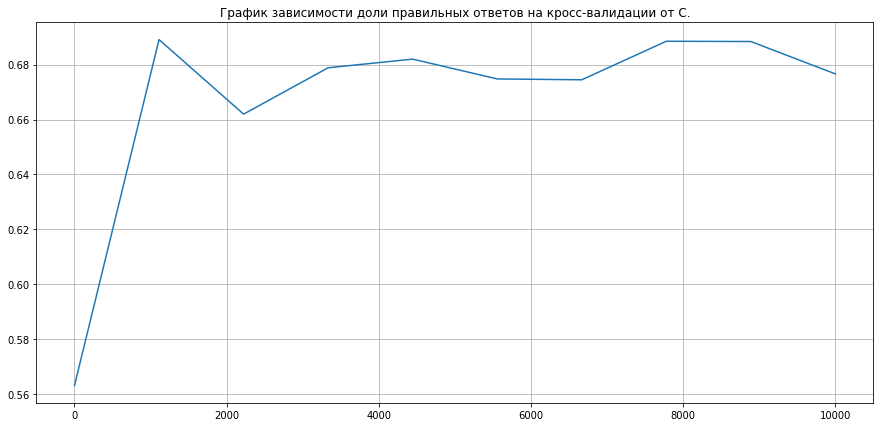

In [74]:
#plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

plt.figure(figsize=(15, 7))
plt.plot(svm_params1['C'], svm_grid_searcher1.cv_results_['mean_test_score'])
#plt.xscale('log')
plt.grid(True)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C.');

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [78]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, cv=skf, n_jobs=-1)
#''' ВАШ КОД ЗДЕСЬ '''
svm_grid_searcher2.fit(X_train, y_train)
print(svm_grid_searcher2.best_score_)
print(svm_grid_searcher2.best_params_)

0.7649867913025807
{'C': 0.24213793103448275}
Wall time: 1min 10s


In [80]:
svm_grid_searcher2

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.00...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, ve

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [77]:
#''' ВАШ КОД ЗДЕСЬ '''
print(svm_grid_searcher2.best_score_)
print(svm_grid_searcher2.best_params_)

0.7661044503149766
{'C': 0.13879310344827586}


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

In [ ]:
#plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)
plt.figure(figsize=(15, 7))
plt.plot(svm_params2['C'], svm_grid_searcher2.cv_results_['mean_test_score'])
#plt.xscale('log')
plt.grid(True)
plt.title('График зависимости доли правильных ответов на кросс-валидации от C.');

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [ ]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
#''' ВАШ КОД ЗДЕСЬ '''
print('доля правильных ответов на отложенной выборке {:.3f}'.format(svm_cv_acc))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
svm_grid_searcher2

In [ ]:
#''' ВАШ КОД ЗДЕСЬ '''
#ans_4_0 = test_KNeighbors(svm_grid_searcher2, X_train, y_train)

#ascores3 = np.array(next(iter(svm_grid_searcher2.scores_.values()))).mean(axis=0)
#logit_mean_cv_scores2 = ascores3.mean(axis=0)

#ans_4_00 = ans_3_0 = logit_mean_cv_scores2[best_pos2]


ans_4_00 = cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf).mean()

#ans_4_1 = svm_grid_searcher2.best_estimator_.score(X_valid, y_valid)

print('{:.3f}, {:.3f}'.format(ans_4_00, svm_cv_acc))
#save_answer_Array(4, [ans_4_00, ans_4_1])

In [ ]:
save_answer_Array(4, [ans_4_00, svm_cv_acc])

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) 
    share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) 
    where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start_time = time.time()
    with open(path_to_X_pickle, 'rb') as f:
        X = pickle.load(f)
    with open(path_to_y_pickle, 'rb') as f:
        y = pickle.load(f)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    estimator.fit(X_train, y_train)
    return (cross_val_score(estimator, X_train, y_train, cv=cv).mean(), 
            estimator.score(X_valid, y_valid),
            time.time() - start_time
           )
    #''' ВАШ КОД ЗДЕСЬ '''

**Убедитесь, что функция работает.**

In [ ]:
svm_grid_searcher2.best_estimator_

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!copy $PATH_TO_DATA\X_sparse_10users.pkl $PATH_TO_DATA\X_sparse_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\X_sparse_150users.pkl $PATH_TO_DATA\X_sparse_150users_s10_w10.pkl 
!copy $PATH_TO_DATA\y_10users.pkl $PATH_TO_DATA\y_10users_s10_w10.pkl 
!copy $PATH_TO_DATA\y_150users.pkl $PATH_TO_DATA\y_150users_s10_w10.pkl 

In [ ]:
%%time
nusers = 10
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
        print (model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
%%time
#''' ВАШ КОД ЗДЕСЬ '''
session_length, window_size, nusers = 15, 5, 10
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
ans_5 = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)


In [ ]:
print('{:.3f}, {:.3f}'.format(ans_5[0], ans_5[1]))
save_answer_Array(5, [ans_5[0], ans_5[1]])

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
nusers = 150
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
    print (model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf))

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
%%time
#''' ВАШ КОД ЗДЕСЬ '''
session_length, window_size, nusers = 10, 10, 150
path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_{}users_s{:02d}_w{:02d}.pkl'.format(nusers, session_length, window_size))
ans_6 = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf)

In [ ]:
print('{:.3f}, {:.3f}'.format(ans_6[0], ans_6[1]))
save_answer_Array(6, [ans_6[0], ans_6[1]])

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [55]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [56]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

<font color='red'>
Выяснить, почему правильно logit_grid_searcher2.Cs_[10]
 </font>

In [91]:
%%time
## пробовал 1.5526315789473686, 0.13879310344827586 0.24213793103448275
## 3.7315789473684213 (Cs_[10])

logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], cv=skf, multi_class='ovr', 
                                            n_jobs=-1, random_state=17)
#''' ВАШ КОД ЗДЕСЬ '''
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 9min 40s


In [90]:
# В форуме предлагается использовать
logit_grid_searcher2.Cs_[10]
#logit_grid_searcher2

3.7315789473684213

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [82]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))
#''' ВАШ КОД ЗДЕСЬ '''

User 6, CV score: 0.9956415402403911
User 13, CV score: 0.9961943357787794
User 15, CV score: 0.9950996857914354
User 16, CV score: 0.9914820590549279
User 28, CV score: 0.9897822641072268
User 31, CV score: 0.9946200496111605
User 33, CV score: 0.993473120432259
User 39, CV score: 0.985945420758278
User 46, CV score: 0.9978627540055065
User 49, CV score: 0.9946412629917414
User 50, CV score: 0.9943492914137165
User 53, CV score: 0.9934422706266065
User 65, CV score: 0.9969243788014506
User 66, CV score: 0.9949433039535792
User 82, CV score: 0.9963509302040569
User 85, CV score: 0.9963404462735808
User 89, CV score: 0.99035590061778
User 92, CV score: 0.9942863960888061
User 100, CV score: 0.994713945830726
User 102, CV score: 0.9911168820885936
User 103, CV score: 0.9792938096854478
User 105, CV score: 0.9966635776191616
User 106, CV score: 0.994286759291183
User 118, CV score: 0.9903663143178446
User 119, CV score: 0.996444751353168
User 120, CV score: 0.9941300796413183
User 126, CV

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [63]:
logit_cv_150users.scores_[6].mean()

0.9960063079741522

In [ ]:
(y_train_150.shape[0] - class_distr[6])/y_train_150.shape[0]

In [92]:
class_distr = np.bincount(y_train_150.astype('int'))
#print(class_distr.sum())
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] =  logit_cv_150users.scores_[user_id].mean() - 1. + 1.*class_distr[user_id]/y_train_150.shape[0]
    
#    ''' ВАШ КОД ЗДЕСЬ '''


In [93]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
print(num_better_than_default)
# Не правильно 129, 134, 136, 121

121


In [ ]:
np.array(list(acc_diff_vs_constant.values())) > 0

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [94]:
#''' ВАШ КОД ЗДЕСЬ '''
ans_7 = num_better_than_default/len(np.unique(y_train_150))
print('{:.3f}'.format(ans_7))
save_answer_Array(7, [ans_7])
# Не правильно 0.860 0.907 
#Правильно: 0.807

0.807


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.